<a href="https://colab.research.google.com/github/owenburton/DS-Unit-2-Kaggle-Challenge/blob/master/module4/assignment_kaggle_challenge_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Kaggle Challenge, Module 4

## Assignment
- [x] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [x] Plot a confusion matrix for your Tanzania Waterpumps model.
- [x] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 60% accuracy (above the majority class baseline).
- [x] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [x] Commit your notebook to your fork of the GitHub repo.
- [x] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading
- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Simple guide to confusion matrix terminology](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/) by Kevin Markham, with video
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)
- [ ] Stacking Ensemble. (See below)

### Stacking Ensemble

Here's some code you can use to "stack" multiple submissions, which is another form of ensembling:

```python
import pandas as pd

# Filenames of your submissions you want to ensemble
files = ['submission-01.csv', 'submission-02.csv', 'submission-03.csv']

target = 'status_group'
submissions = (pd.read_csv(file)[[target]] for file in files)
ensemble = pd.concat(submissions, axis='columns')
majority_vote = ensemble.mode(axis='columns')[0]

sample_submission = pd.read_csv('sample_submission.csv')
submission = sample_submission.copy()
submission[target] = majority_vote
submission.to_csv('my-ultimate-ensemble-submission.csv', index=False)
```

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [0]:
from sklearn.model_selection import train_test_split
import numpy as np

target = 'status_group'
train, val = train_test_split(train, test_size=len(test), stratify=train[target],
                              random_state=42)
def wrangle(X):
  X = X.copy()

  X['latitude'] = X['latitude'].replace(-2e-08, 0)

  cols_with_zeroes = ['longitude', 'latitude', 'construction_year', 'gps_height', 
                      'population']
  for col in cols_with_zeroes:
    X[col] = X[col].replace(0, np.nan)
    X[col+'_MISSING'] = X[col].isnull()

  dropped = ['quantity_group', 'payment_type', 'recorded_by', 'id']
  X = X.drop(columns=dropped)
  
  dr = 'date_recorded'
  X[dr] = pd.to_datetime(X[dr], infer_datetime_format=True)
  
  X['year_recorded'] = X[dr].dt.year
  X['month_recorded'] = X[dr].dt.month 
  X['day_recorded'] = X[dr].dt.day
  X = X.drop(columns=dr)

  X['years'] = X['year_recorded'] - X['construction_year']
  X['years_missing'] = X['years'].isnull()

  return X

In [0]:
train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test

In [0]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from lightgbm import LGBMClassifier

In [0]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    LGBMClassifier(random_state=42)
)

pipeline.fit(X_train, y_train);

In [0]:
y_pred = pipeline.predict(X_val)

In [0]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred):
  labels = unique_labels(y_true)
  columns = [f'Predicted {label}' for label in labels]
  index = [f'Actual {label}' for label in labels]
  table = pd.DataFrame(confusion_matrix(y_true, y_pred),
                       columns=columns, index=index)
  return sns.heatmap(table, annot=True, fmt='d', cmap='viridis')


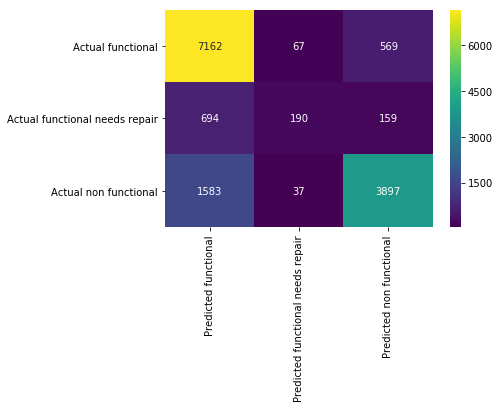

In [36]:
plot_confusion_matrix(y_val, y_pred);

In [38]:
print(classification_report(y_val, y_pred))

                         precision    recall  f1-score   support

             functional       0.76      0.92      0.83      7798
functional needs repair       0.65      0.18      0.28      1043
         non functional       0.84      0.71      0.77      5517

               accuracy                           0.78     14358
              macro avg       0.75      0.60      0.63     14358
           weighted avg       0.78      0.78      0.77     14358

